In [1]:
%matplotlib notebook
import cytoflow as flow

/Users/george/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/george/anaconda/envs/py27/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.


<b>STEP 1</b>

> Specify folder where data files are located. All files are read and appended into a single pandas.DataFrame named 'ex' with additional attribute(parameter) equal to corresponding filename.  
Numeric data from the beginning of the filename is parsed as float number and used as 'concentration' condition

> Note that 'concentration' condition may be string as well. But in this case either the number of conditions should not exeed six or you will have to avoid 'huefacet' and 'hue' options in graphics since default palette has only six colors. Instead of 'hue' you can use "yfacet = 'concentration'" to arrange graphics one by one or just nothing to plot all data in a single color on a single graph

In [2]:
data_files="data/AgTx-raw/*.fcs"
import glob
import re
names=[]
tubes=[]
concentrations=[]
for file_name in glob.iglob(data_files): 
    name = '.'.join(file_name.split("\\")[-1].split("/")[-1].split('.')[:-1]); # "\\" - for Windows, "/" - for UNIX
    names.append(name)
    conc = re.findall(r'[0-9.]+', name)[0]
    concentrations.append(conc) #list of concentrations available
    tube=flow.Tube(file=file_name, conditions={'concentration' : conc})
    tubes.append(tube)
import_op = flow.ImportOp(conditions = {'concentration' : "float"}, tubes = tubes) 
#'concentration' can be "string" as well. But max 6 entries are possible for use with with huefacet option below

#some checkpoints:
print "Imported names: " + ' '.join(names)
print "Parsed concentrations: " + ' '.join(concentrations) #display imported concentrations that will be used to refer specific data
ex = import_op.apply() 
print "\n Event count for each condition :"
print ex.data.groupby(['concentration']).size() #display event number for each condition
print "\n First five data entries"
ex.data.head() #display first five data entries

Imported names: 0.03nM 0.1nM 0.32nM 0nM 100nM 10nM 1nM 3.2nM 32nM
Parsed concentrations: 0.03 0.1 0.32 0 100 10 1 3.2 32

 Event count for each condition :
concentration
0.00      116608
0.03       63332
0.10       49353
0.32       48255
1.00       40570
3.20       44139
10.00      38840
32.00      38813
100.00     42692
dtype: int64

 First five data entries


,Event #,FL1,FL2,FL3,FL4,FL5,FS,SS,TIME,concentration
0,0.0,2174.0,3461.0,11289.0,1935.0,1861.0,27776.0,12589.0,1.0,0.03
1,1.0,4686.0,1800.0,8336.0,1909.0,1654.0,607.0,11084.0,1.0,0.03
2,2.0,3738.0,1659.0,8230.0,715.0,1153.0,32000.0,12288.0,1.0,0.03
3,3.0,7236.0,4679.0,6941.0,4360.0,2782.0,13899.0,29600.0,1.0,0.03
4,4.0,2265.0,3008.0,10752.0,2273.0,2816.0,84352.0,12374.0,1.0,0.03


<b>STEP 2</b>

>Data from different files are imaged in different collors by "huefacet = 'concentration'" condition

>Specify a poligon gate here that will be used for further analysis. Single click to set vertices; double-click when you're done. JavaScript is slow here so be patient.  

>You can zoom the data first. This will initiate a polygon as well. You will need to finalize this gate by double click and draw the correct one.  

<IPython.core.display.Javascript object>


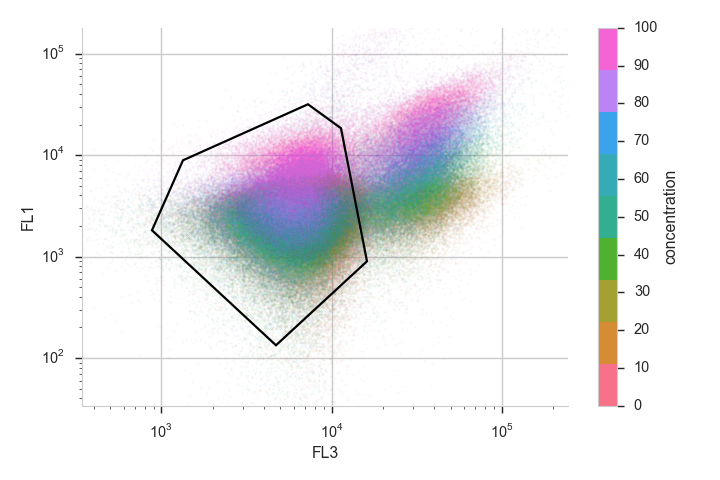

In [7]:
x_channel = 'FL3'
y_channel = 'FL1'
flow.set_default_scale("log") #set default axis to log
p = flow.PolygonOp(name = "Polygon",
                   xchannel = x_channel,
                   ychannel = y_channel)
p_view = p.default_view(huefacet="concentration", 
                        interactive = True).plot(ex, alpha =0.05),

<b>STEP 3</b>

>Run bellow to apply the gate to the data, extract x_channel and y_channel data and create their log counterparts

>If there is no polynomal gate on the image above this spep will process all data 

In [6]:
from numpy import log10
print len(p.vertices)

if len(p.vertices)>2: 
    ex2=p.apply(ex) #add atitional boolean condition 'Polygon' whether event is within gate or not
    #log_data is an exctaction of desired channels that are within Range2D gate and futher log10 of its values
    gated_data = ex2.data.loc[ex2.data["Polygon"]][[x_channel,y_channel,'concentration']]
else:
    gated_gata=ex2.data[[x_channel,y_channel,'concentration']]
gated_data['x_channel_log']=gated_data[x_channel].apply(log10)
gated_data['y_channel_log']=gated_data[y_channel].apply(log10)

print "Gated data (Concentration/Event count):",
print gated_data.groupby(['concentration']).size()
gated_data.head(5)

8
Gated data (Concentration/Event count): concentration
0.00       6493
0.03       7597
0.10       9518
0.32      10361
1.00       8736
3.20      10664
10.00     11781
32.00      9338
100.00    15424
dtype: int64


,FL3,FL1,concentration,x_channel_log,y_channel_log
8,23073.0,3280.0,0.03,4.363104,3.515874
10,25808.0,4559.0,0.03,4.411754,3.658870
16,16309.0,4775.0,0.03,4.212427,3.678973
24,22929.0,2793.0,0.03,4.360385,3.446071
34,57152.0,4773.0,0.03,4.757031,3.678791


### STEP 3a ###

> Writes negative data to separate DataFrame (neg_gated_data). Restart <b>STEP 2</b> in order to redraw polygon gate and apply in in this step below.  

In [8]:
ex3=p.apply(ex) #add atitional boolean condition 'Range2D' whether event is within gate or not
from numpy import log10
#log_data is an exctaction of desired channels that are within Range2D gate and futher log10 of its values
neg_gated_data = ex3.data.loc[ex3.data["Polygon"]][[x_channel,y_channel,'concentration']]
neg_gated_data['x_channel_log']=neg_gated_data[x_channel].apply(log10)
neg_gated_data['y_channel_log']=neg_gated_data[y_channel].apply(log10)
print "Negative data:"
neg_gated_data.head(5)

Negative data:


,FL3,FL1,concentration,x_channel_log,y_channel_log
0,11289.0,2174.0,0.03,4.052655,3.337260
1,8336.0,4686.0,0.03,3.920958,3.670802
2,8230.0,3738.0,0.03,3.915400,3.572639
3,6941.0,7236.0,0.03,3.841422,3.859499
4,10752.0,2265.0,0.03,4.031489,3.355068


### STEP 4 ###

> Fit positive data with linear function: y = slope*x + intercept. Other functions can be used as well. In this case slope and intercept will be irrelevant but fitting results will be stored in popt value. This is a list of constants that are obtained from fitting. It will be used to polt fitting curver in next step.    

> Results of this fit are recorded to 'results' table (DataFrame) that is displayed below

In [9]:
def func(x, slope,intercept):
    return slope*x+intercept

import pandas as pd
from scipy.optimize import curve_fit
i=0
results=pd.DataFrame(columns=['concentration','slope','intercept','popt'])
concentrations = gated_data['concentration'].unique().tolist()
concentrations.sort()
for conc in concentrations:
    popt, pconv = curve_fit(func,
                            gated_data[(gated_data.concentration==conc)]['x_channel_log'],
                            gated_data[(gated_data.concentration==conc)]['y_channel_log'], maxfev=10000)
    
    results.loc[i]=pd.Series({'concentration':conc,'slope':popt[0],'intercept':popt[1],'popt':popt})
    i=i+1

results.sort_values(by='concentration')

,concentration,slope,intercept,popt
0,0.00,0.029777,3.391334,"[0.0297766193833, 3.39133435491]"
1,0.03,0.152640,2.861670,"[0.152639700371, 2.86167017812]"
2,0.10,0.325361,2.051837,"[0.325361038584, 2.0518369532]"
3,0.32,0.655642,0.703966,"[0.655641955179, 0.703966420995]"
4,1.00,0.798449,0.135234,"[0.79844875184, 0.135233642763]"
5,3.20,0.893308,-0.204500,"[0.893307831877, -0.204499704771]"
6,10.00,0.937163,-0.250653,"[0.937162592104, -0.250652887149]"
7,32.00,0.981083,-0.314375,"[0.981082846345, -0.314374572914]"
8,100.00,0.916967,0.153405,"[0.916967120864, 0.153405217385]"


### STEP 4a ###

>Plot scatter plots and corresponding fitting curves on separate graphs

<IPython.core.display.Javascript object>


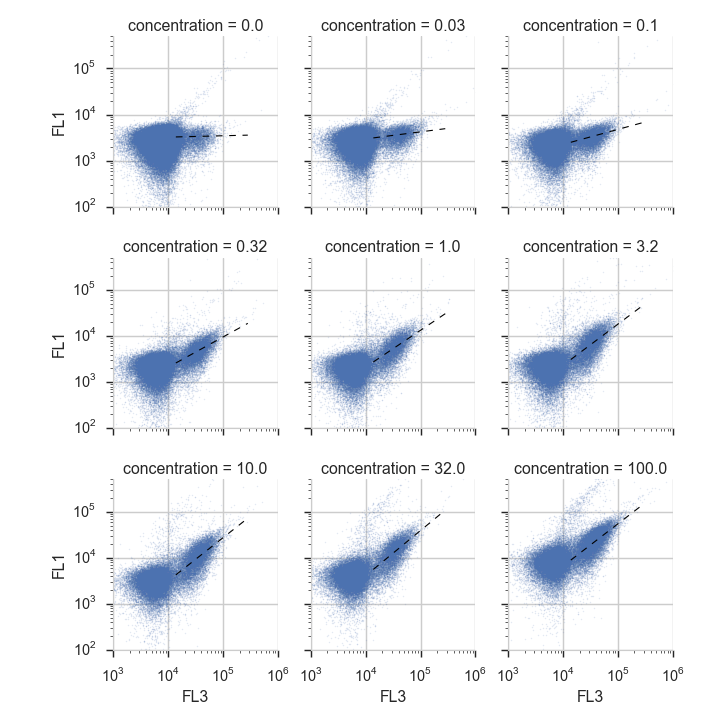

In [10]:
import seaborn as sns
import pylab as plt
import numpy as np

g = sns.FacetGrid(ex.data, col="concentration", col_wrap=3, size=3)
g.map(plt.scatter, x_channel, y_channel, s=1, alpha=0.1);
g.set(yscale='log', xscale='log', xlim=(1000,1000000), ylim=(100,500000))
g.fig.subplots_adjust(wspace=.2, hspace=.3)

for conc, ax in zip(concentrations, g.axes.flat):
    popt= np.ravel(np.array(results.loc[results.concentration==conc]['popt'].tolist()))

    x = np.arange(gated_data[x_channel].min(), gated_data[x_channel].max(), 1000)
    curve = pow(10,func(log10(x),*popt))
    ax.plot(x,curve,'k--', linewidth=1.0, label=''.join(['Slope = ', str(np.round(popt[0],2))]))

> <b>These fitting results may be already good enough and the job is done!</b> 

>But sometimes you may want to fit your data little more. Following procedure is dedicated to process ligand-receptor binding data that is analyzed by <b>linear</b> regression. This procedure will take into account background level and equilibrate interception of inclined fitting line with the corresponding background for all samples. 


### STEP 5 ###

> Fit negative controls with horisontal line corresponding to mean (or median in log scale) of y_channel value 

> Calculate an x coordinate of intercept between linear fit of positive data and backgroung horizontal line (x_bg_intercept). Ideally this value should be the same for all data. Further procedure will force this equality. 

> This step requires <b>STEP 3a</b> that apllies gate on negative population

In [11]:
for conc in concentrations:
    results.set_value(results.concentration==conc, 'background', # popt[0])
                     neg_gated_data[(neg_gated_data.concentration==conc)]['y_channel_log'].median())

def find_intercept(row):
    return (row['background']-row['intercept'])/row['slope']    
results['x_bg_intercept']=results.apply(find_intercept, axis=1)

results.sort_values(by='concentration')

,concentration,slope,intercept,popt,background,x_bg_intercept
0,0.00,0.029777,3.391334,"[0.0297766193833, 3.39133435491]",3.427486,1.214099
1,0.03,0.152640,2.861670,"[0.152639700371, 2.86167017812]",3.410862,3.597959
2,0.10,0.325361,2.051837,"[0.325361038584, 2.0518369532]",3.355643,4.007259
3,0.32,0.655642,0.703966,"[0.655641955179, 0.703966420995]",3.328176,4.002504
4,1.00,0.798449,0.135234,"[0.79844875184, 0.135233642763]",3.320562,3.989396
5,3.20,0.893308,-0.204500,"[0.893307831877, -0.204499704771]",3.353532,3.982985
6,10.00,0.937163,-0.250653,"[0.937162592104, -0.250652887149]",3.498035,4.000040
7,32.00,0.981083,-0.314375,"[0.981082846345, -0.314374572914]",3.615266,4.005412
8,100.00,0.916967,0.153405,"[0.916967120864, 0.153405217385]",3.892150,4.077295


### STEP 6 ###

> Find an average of all x_bg_intercept values after exluding of one highest and one lowest values:

> Force fitting line to pass corresponding background line at x_bg_intercept_mean coordinate.
This is done by linear translation of origin of coordinates to this point and forcing intercept=0 i.e. 
* x' = x - x_bg_intercept_mean
* y' = y - background
* intercept = 0 

> This can be rewritten as:
* y'= slope_corr*x' 
* y = slope_corr*(x-x_bg_intercept_mean)+background

In [12]:
x_bg_intercepts = results['x_bg_intercept'].tolist()
x_bg_intercepts.sort()
x_bg_intercept_mean=sum(x_bg_intercepts[1:-1])/len(x_bg_intercepts[1:-1])
print "average x_bg_intercept = ", x_bg_intercept_mean

for conc in concentrations:
    bkg=float(results[(results.concentration==conc)]['background'])
    popt, pconv = curve_fit(lambda x,slope: func(x-x_bg_intercept_mean,slope,bkg),
                            gated_data[(gated_data.concentration==conc)]['x_channel_log'],
                            gated_data[(gated_data.concentration==conc)]['y_channel_log'], maxfev=10000)
    results.set_value(results.concentration==conc, 'slope_corr', popt[0])
    results.set_value(results.concentration==conc, 'intercept_corr', bkg-x_bg_intercept_mean*popt[0])
                  
results.sort_values(by='concentration')

average x_bg_intercept =  3.94079334508


,concentration,slope,intercept,popt,background,x_bg_intercept,slope_corr,intercept_corr
0,0.00,0.029777,3.391334,"[0.0297766193833, 3.39133435491]",3.427486,1.214099,0.174373,2.740319
1,0.03,0.152640,2.861670,"[0.152639700371, 2.86167017812]",3.410862,3.597959,0.229367,2.506975
2,0.10,0.325361,2.051837,"[0.325361038584, 2.0518369532]",3.355643,4.007259,0.290938,2.209115
3,0.32,0.655642,0.703966,"[0.655641955179, 0.703966420995]",3.328176,4.002504,0.591358,0.997758
4,1.00,0.798449,0.135234,"[0.79844875184, 0.135233642763]",3.320562,3.989396,0.736184,0.419414
5,3.20,0.893308,-0.204500,"[0.893307831877, -0.204499704771]",3.353532,3.982985,0.831565,0.076505
6,10.00,0.937163,-0.250653,"[0.937162592104, -0.250652887149]",3.498035,4.000040,0.849573,0.150043
7,32.00,0.981083,-0.314375,"[0.981082846345, -0.314374572914]",3.615266,4.005412,0.878215,0.154401
8,100.00,0.916967,0.153405,"[0.916967120864, 0.153405217385]",3.892150,4.077295,0.724900,1.035469


### STEP 6a ###

>Plot scatter plots and corrected fitting curves with background on separate graphs

<IPython.core.display.Javascript object>


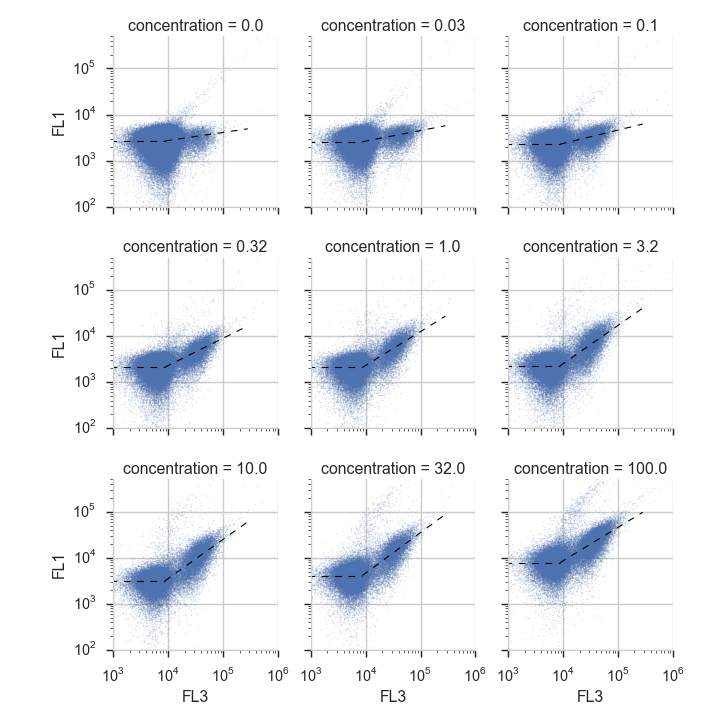

In [13]:
g2 = sns.FacetGrid(ex.data, col="concentration", col_wrap=3, size=3)
g2.map(plt.scatter, x_channel, y_channel, s=1, alpha=0.1);
g2.set(yscale='log', xscale='log', xlim=(1000,1000000), ylim=(100,500000))
g2.fig.subplots_adjust(wspace=.2, hspace=.3)

for conc, ax in zip(concentrations, g2.axes.flat):
    popt= np.ravel([results.loc[results.concentration==conc]['slope_corr'].values,
                    results.loc[results.concentration==conc]['intercept_corr'].values])
   
    x = np.arange(10**x_bg_intercept_mean, gated_data[x_channel].max(), 1000)
    curve = 10**(func(log10(x),*popt)) 
    #plot curve for positive data:  
    ax.plot(x,curve,'k--', linewidth=1.0)
    #plot backgound level
    bg=results.loc[results.concentration==conc]['background'].values
    ax.plot([neg_gated_data[x_channel].min(),10**x_bg_intercept_mean],
            [10**bg, 10**bg], 'k--', linewidth=1.0)